In [1]:
import tensorflow
import keras
from keras.models import Model
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten


In [2]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# === PATHS ===
train_dir =  r'E:\Dataset\Brain_Tumor_Classification\Training'
test_dir  = r'E:\Dataset\Brain_Tumor_Classification\Testing'
img_size  = (224, 224)   # same size you used in your model

# === Helper function ===
def load_dataset(data_dir, img_size):
    X, y = [], []
    classes = sorted(os.listdir(data_dir))
    for label in classes:
        class_path = os.path.join(data_dir, label)
        if not os.path.isdir(class_path):
            continue
        print(f"📂 Loading class: {label}")
        for file in tqdm(os.listdir(class_path), desc=f"{label}"):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, file)
                try:
                    img = load_img(img_path, target_size=img_size, color_mode='rgb')
                    img = img_to_array(img) / 255.0   # normalize 0–1
                    X.append(img)
                    y.append(label)
                except Exception as e:
                    print(f"⚠️ Skipped {img} due to error: {e}")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Train and Test sets ===
X_train, y_train = load_dataset(train_dir, img_size)
X_test,  y_test  = load_dataset(test_dir, img_size)

print(f"\n✅ X_train shape: {X_train.shape}")
print(f"✅ y_train shape: {y_train.shape}")
print(f"✅ X_test shape:  {X_test.shape}")


📂 Loading class: glioma_tumor


glioma_tumor: 100%|██████████| 826/826 [00:04<00:00, 167.15it/s]


📂 Loading class: meningioma_tumor


meningioma_tumor: 100%|██████████| 822/822 [00:03<00:00, 210.25it/s]


📂 Loading class: no_tumor


no_tumor: 100%|██████████| 395/395 [00:01<00:00, 211.37it/s]


📂 Loading class: pituitary_tumor


pituitary_tumor: 100%|██████████| 827/827 [00:02<00:00, 282.66it/s]


📂 Loading class: glioma_tumor


glioma_tumor: 100%|██████████| 100/100 [00:00<00:00, 113.24it/s]


📂 Loading class: meningioma_tumor


meningioma_tumor: 100%|██████████| 115/115 [00:00<00:00, 146.36it/s]


📂 Loading class: no_tumor


no_tumor: 100%|██████████| 105/105 [00:00<00:00, 123.36it/s]


📂 Loading class: pituitary_tumor


pituitary_tumor: 100%|██████████| 74/74 [00:00<00:00, 83.06it/s] 


✅ X_train shape: (2870, 224, 224, 3)
✅ y_train shape: (2870,)
✅ X_test shape:  (394, 224, 224, 3)


In [3]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test  = label_encoder.transform(y_test)

print("Classes found:", label_encoder.classes_)


Classes found: ['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


In [4]:
y_train

array([0, 0, 0, ..., 3, 3, 3])

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Suppose your labels are in a numpy array: y_train
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))


In [6]:
class_weight_dict

{0: np.float64(0.8686440677966102),
 1: np.float64(0.8728710462287105),
 2: np.float64(1.8164556962025316),
 3: np.float64(0.8675937122128174)}

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

model1 = keras.Sequential([
    layers.Dense(256, input_shape=(150528,), name='dense_17'),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])


f:\Anaconda\envs\new_env\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,568,836 (147.13 MB)

 Trainable params: 38,568,836 (147.13 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
## Compile the model ###

from tensorflow.keras.optimizers import Adam


model1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])


In [10]:
X_train_flat = X_train.reshape((2870, -1))  # flatten to (2870, 150528)
X_test_flat = X_test.reshape((394, -1))    # flatten to (394, 150528)


In [11]:
## Train the model ###

model1.fit(
    X_train_flat,
    y_train,
    epochs=10,
    validation_data=(X_test_flat, y_test),
    class_weight=class_weight_dict,
    batch_size=32,
    shuffle=True
)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 230ms/step - accuracy: 0.5021 - loss: 1.9345 - val_accuracy: 0.3883 - val_loss: 4.8159
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.6711 - loss: 1.0585 - val_accuracy: 0.3959 - val_loss: 4.1007
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 0.7080 - loss: 0.9129 - val_accuracy: 0.5914 - val_loss: 3.0094
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.7826 - loss: 0.5946 - val_accuracy: 0.5482 - val_loss: 2.8819
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.7666 - loss: 0.6958 - val_accuracy: 0.6218 - val_loss: 3.5775
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.7969 - loss: 0.5782 - val_accuracy: 0.5533 - val_loss: 4.3541
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 229ms/step - accuracy: 0.8624 - loss: 0.3437 - val_accuracy: 0.6853 - val_loss: 3.8137
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - accuracy: 0.8850 - loss: 0.2772 - val_accu

In [12]:
# Run inference at least once to build input/output tensors
_ = model1.predict(np.zeros((1, 150528)))

# Suppose you want the 0th (first) image from X_train_flat
single_img = X_train_flat[0] 

# Add a batch dimension
single_img = np.expand_dims(single_img, axis=0)  # shape: (1, 150528)

# Now you can use outputs from intermediate layers:
layer = model1.get_layer('dense_17')
layer_model = Model(inputs=layer.input, outputs=layer.output)
activations_17 = layer_model.predict(single_img)
weight_17 = layer.get_weights()
print(activations_17.shape)
print(weight_17[0].shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
(1, 256)
(150528, 256)


In [13]:
y_train[0]

np.int64(0)

In [14]:
single_img = X_train_flat[0]
single_img = np.expand_dims(single_img, axis=0)

In [15]:
R5 = model1.predict(single_img)
R5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([[0.9733531 , 0.00713391, 0.01735347, 0.00215948]], dtype=float32)

In [17]:
layer = model1.get_layer('dense_17')
W1, B1 = layer.get_weights()

print("Weight matrix shape:", W1.shape)  # e.g. (input_dim, units)
print("Bias vector shape:", B1.shape)     # e.g. (units,)


Weight matrix shape: (150528, 256)
Bias vector shape: (256,)


In [18]:
layer = model1.get_layer('dense')
W2, B2 = layer.get_weights()

print("Weight matrix shape:", W2.shape)  # e.g. (input_dim, units)
print("Bias vector shape:", B2.shape)     # e.g. (units,)

Weight matrix shape: (256, 128)
Bias vector shape: (128,)


In [19]:
layer = model1.get_layer('dense_1')
W3, B3 = layer.get_weights()

print("Weight matrix shape:", W3.shape)  # e.g. (input_dim, units)
print("Bias vector shape:", B3.shape)     # e.g. (units,)

Weight matrix shape: (128, 4)
Bias vector shape: (4,)


In [20]:
def softmax(x):
    x_shifted = x - np.max(x)      # improves numerical stability
    z = np.exp(x_shifted)
    p = np.sum(z)
    r = z/p
    return r


In [21]:
A0 = X_train_flat[0]  # shape: (150528,)
Z1 = np.dot(A0, W1) + B1
A1 = np.maximum(0, Z1)
Z2 = np.dot(A1, W2) + B2
A2 = np.maximum(0, Z2)
Z3 = np.dot(A2, W3) + B3
A3 = softmax(Z3)   # softmax output, shape: (4,)
A3


array([0.5140784 , 0.20383157, 0.05218055, 0.22990948], dtype=float32)

In [22]:
target_class = np.argmax(A3)

R3 = np.zeros_like(A3)
R3[target_class] = A3[target_class]


In [24]:
epsilon = 1e-9

# For output-to-second-last layer (layer 3→2)
z_k = epsilon + np.dot(A2, W3)  # shape: (4,)
s_k = R3 / z_k                  # shape: (4,)

c_j = np.dot(W3, s_k)           # shape: (128,)
R2 = A2 * c_j                   # shape: (128,)

# For second to first hidden (layer 2→1)
z_k = epsilon + np.dot(A1, W2)
s_k = R2 / z_k
c_j = np.dot(W2, s_k)
R1 = A1 * c_j

# For first hidden to input (layer 1→0)
z_k = epsilon + np.dot(A0, W1)
s_k = R1 / z_k
c_j = np.dot(W1, s_k)
R0 = A0 * c_j


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9213538..1.0].


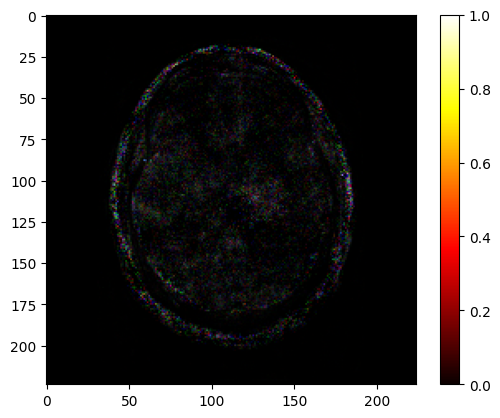

In [26]:
import matplotlib.pyplot as plt

img_shape = (224, 224, 3)
heatmap_norm = R0 / np.max(R0)
plt.imshow(heatmap_norm.reshape(img_shape), cmap='hot')
plt.colorbar()
plt.show()


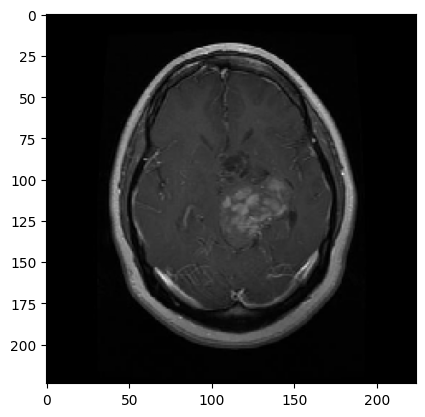

In [27]:
plt.imshow(X_train[0])

In [ ]:
def rho(W,l):  return W + [None,0.1,0.0,0.0][l] * numpy.maximum(0,W)
def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9


In [29]:
L = 3

In [37]:
epsilon = 1e-9

W3 = W3 + [None,0.1,0.0,0.0][3]*np.maximum(0,W3)

# For output-to-second-last layer (layer 3→2)
z_k = epsilon + np.dot(A2, W3)  # shape: (4,)
z_k = z_k + [None,0.0,0.1,0.0][3]*(z_k**2).mean()**.5+1e-9
s_k = R3 / z_k                  # shape: (4,)

c_j = np.dot(W3, s_k)           # shape: (128,)
R2 = A2 * c_j                   # shape: (128,)

# For second to first hidden (layer 2→1)
W2 = W2 + [None,0.1,0.0,0.0][2]*np.maximum(0,W2)
z_k = epsilon + np.dot(A1, W2)
z_k = z_k + [None,0.0,0.1,0.0][2]*(z_k**2).mean()**.5+1e-9
s_k = R2 / z_k
c_j = np.dot(W2, s_k)
R1 = A1 * c_j

# For first hidden to input (layer 1→0)
W1 = W1 + [None,0.1,0.0,0.0][2]*np.maximum(0,W1)
z_k = epsilon + np.dot(A0, W1)
z_k = z_k + [None,0.0,0.1,0.0][3]*(z_k**2).mean()**.5+1e-9
s_k = R1 / z_k
c_j = np.dot(W1, s_k)
R0 = A0 * c_j



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0926787..1.0].


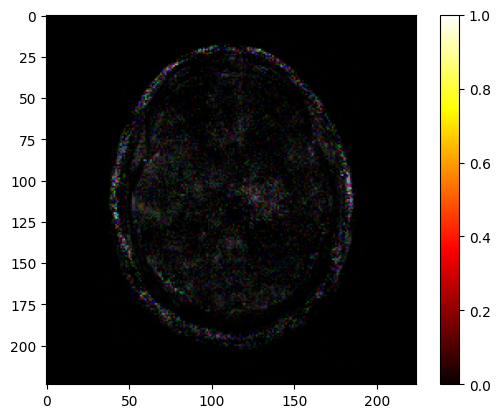

In [38]:
import matplotlib.pyplot as plt

img_shape = (224, 224, 3)
heatmap_norm = R0 / np.max(R0)
plt.imshow(heatmap_norm.reshape(img_shape), cmap='hot')
plt.colorbar()
plt.show()

In [49]:
import cv2
img = np.expand_dims(X_train[0], axis=0)
img = img/255.0


In [53]:
import torch

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

X = (img - mean) / std
